In [72]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import SGD
from torch.utils.data import DataLoader

from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

import warnings 

warnings.filterwarnings('ignore')

<br/> 

## Överblick

**Nu ska vi träna Neurala Nätverk och få lite praktiskt erfarenhet av Hyperparameters**

Vi kommer bygga och träna Neurala Nätverk för att lösa regressionsproblem.

**GRAFIKKORTSACCELERATION**

Kolla om GPU-acceleration är tillgänligt

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Available device: {device}")

Available device: cuda


## Data

Vi ska använda oss av Seol bicycle demand data, och träna modeller att kunna predicta... just det, bicycle demand per dag.  

Datat kommer från https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

**Som vanligt går ni in där för att läsa på mer om respektive feature!**

In [74]:
demand_df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
demand_df

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


Nästan alla features ser rätt nice ut och värda att behålla, men vi kommer göra en förenkling. Vi tar för givet att det endast spelar roll huruvida aktuell dag är en helgdag eller inte. Dvs, vi bryr oss inte om exakt vilken dag det är. Vi kan således ta bort kolumnen 'Date' eftersom att vi har en annan kolumn 'Holiday' som anger om det är helgdag eller ej.
  

In [75]:
demand_df = demand_df[demand_df.columns[1:]] # exludera första kolumnen (Date)
demand_df

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [76]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8760 non-null   int64  
 1   Hour                       8760 non-null   int64  
 2   Temperature(°C)            8760 non-null   float64
 3   Humidity(%)                8760 non-null   int64  
 4   Wind speed (m/s)           8760 non-null   float64
 5   Visibility (10m)           8760 non-null   int64  
 6   Dew point temperature(°C)  8760 non-null   float64
 7   Solar Radiation (MJ/m2)    8760 non-null   float64
 8   Rainfall(mm)               8760 non-null   float64
 9   Snowfall (cm)              8760 non-null   float64
 10  Seasons                    8760 non-null   object 
 11  Holiday                    8760 non-null   object 
 12  Functioning Day            8760 non-null   object 
dtypes: float64(6), int64(4), object(3)
memory usage:

Nu återstår fyra kolumner kvar som vi behöver specialanpassa. Dels har vi Hour och Seasons, som både är kategoriska. Därefter har vi också Holiday och Functioning Day som är binära, men behöver omvandlas till siffor.

In [77]:
print(demand_df['Holiday'].value_counts(), end = '\n\n')
print(demand_df['Functioning Day'].value_counts(), end = '\n\n')
print(demand_df['Seasons'].value_counts(), end = '\n\n')
print(demand_df['Hour'].value_counts(), end = '\n\n')

Holiday
No Holiday    8328
Holiday        432
Name: count, dtype: int64

Functioning Day
Yes    8465
No      295
Name: count, dtype: int64

Seasons
Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: count, dtype: int64

Hour
0     365
1     365
2     365
3     365
4     365
5     365
6     365
7     365
8     365
9     365
10    365
11    365
12    365
13    365
14    365
15    365
16    365
17    365
18    365
19    365
20    365
21    365
22    365
23    365
Name: count, dtype: int64



**Omvandla binära kolumner till 1/0.**

In [78]:
binary_columns = ['Holiday', 'Functioning Day']

for column in binary_columns:
    
    first_value = demand_df[column].unique()[0] # extrahera ett av de binära värdena
    transformed_column = [1 if value == first_value else 0 for value in demand_df[column]]
    
    demand_df[column] = transformed_column

In [79]:
demand_df

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,1,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,1,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,1,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,1,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,1,1
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,1,1
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,1,1
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,1,1


**Kolumnen Hour**

Att direkt göra en One-Hot-encoding av Hour skulle ger oss alldeles för många nya kolumner. Istället konstruerar vi färre kategorier genom att klumpa ihop
följande tidsspann

0-5

6-11

12-17

18-23



In [80]:
new_hours = []                            # en lista som indikerar den nya kategorin för varje träningsinstans

for hour in demand_df['Hour']:

    if hour in range(0,6):
        new_hours.append(0)

    elif hour in range(6, 12):
        new_hours.append(1)
    
    elif hour in range(12, 18):
        new_hours.append(2)

    elif hour in range(18, 24):
        new_hours.append(3)

In [81]:
demand_df['Hour'] = new_hours           # ersätt Hour med våra nya värden

demand_df['Hour'].value_counts()

Hour
0    2190
1    2190
2    2190
3    2190
Name: count, dtype: int64

**Omvandla kategoriska kolumner med One Hot Encoding**

In [82]:
set(demand_df['Seasons'])

{'Autumn', 'Spring', 'Summer', 'Winter'}

In [83]:
# För varje möjlig kategoriskt värde, loopa och konstruera en ny kolumn enligt ovan

categorical_columns = ['Seasons', 'Hour']

for column in categorical_columns:
    for value in set(demand_df[column].values):
    
        onehotencode = [1 if x == value else 0 for x in demand_df[column]]
        demand_df[value] = onehotencode
    

#slutligen, droppa orginalkolumnen som vi inte längre behöver    

for column in categorical_columns:
    demand_df = demand_df.drop(columns=[column])

In [84]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8760 non-null   int64  
 1   Temperature(°C)            8760 non-null   float64
 2   Humidity(%)                8760 non-null   int64  
 3   Wind speed (m/s)           8760 non-null   float64
 4   Visibility (10m)           8760 non-null   int64  
 5   Dew point temperature(°C)  8760 non-null   float64
 6   Solar Radiation (MJ/m2)    8760 non-null   float64
 7   Rainfall(mm)               8760 non-null   float64
 8   Snowfall (cm)              8760 non-null   float64
 9   Holiday                    8760 non-null   int64  
 10  Functioning Day            8760 non-null   int64  
 11  Summer                     8760 non-null   int64  
 12  Spring                     8760 non-null   int64  
 13  Autumn                     8760 non-null   int64

**Kontrolluppgift: Kolla så att datan är enligt förväntan, samt att alla kolumner nu är antingen int eller float**

## Dela upp data i train/test

Vi väljer återigen proportionen 90% / 10%

In [85]:
target_column = demand_df.columns[0]
feature_columns = demand_df.columns[1:]

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(demand_df[feature_columns],         
                                                    demand_df[target_column],
                                                    test_size=0.1, 
                                                    random_state=42)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(7884, 18)
(7884,)
(876, 18)
(876,)


<br/>

**Skala data**

Nu  när vi delat upp data i train och test kan vi utföra de mer invasiva transformationerna, som att skala kolumner. **Kom dock ihåg att det är superviktigt att vi endast använder statistik från train split när vi transformerar, annars riskerar vi informationsläckage!** 

Det enda vi egentligen behöver skala om feature kolumnerna så att samtliga värden, till absolutbeloppet, inte blir särskilt mycket större än 1. Kikar vi lite snabbt på vår data så ser vi att så inte är fallet.

Vi återanvänder vårt trick för att åstadkomma detta: att helt enkelt dela respektive kolumn, med det (till absolutbeloppet) högsta värdet. Då kommer samtliga värden skalas ner, och det högsta värdet i respektive kolumn vara (i absolut värde) 1.

In [86]:
feature_columns

Index([          'Temperature(°C)',               'Humidity(%)',
                'Wind speed (m/s)',          'Visibility (10m)',
       'Dew point temperature(°C)',   'Solar Radiation (MJ/m2)',
                    'Rainfall(mm)',             'Snowfall (cm)',
                         'Holiday',           'Functioning Day',
                          'Summer',                    'Spring',
                          'Autumn',                    'Winter',
                                 0,                           1,
                                 2,                           3],
      dtype='object')

In [87]:
for column in feature_columns:                               # iterera över alla input features
    
    highest_value = max(np.abs(x_train[column]))    # hitta det, till absolutbeloppet, högsta värdet i aktuella kolumn i x_train
    
    
    # dela nu aktuell kolumn i x_train med det nyfunna högsta värdet
    
    x_train[column] = x_train[column] / highest_value 
    
    # dela nu även motsvarande kolumn i x_test med SAMMA nyfunna högsta värde (från x_train)
    
    x_test[column] = x_test[column] / highest_value

**KONTROLLUPPGIFT: Kolla så att vi åstadkommit transformationerna vi eftersökte** 

<br/>

**Omvandla till Tensor**

Nu när siffrorna ser bra ut återstår det att omvandla till datatypen Tensor (optimal för PyTorch)

In [88]:
torch.from_numpy(np.array(x_train))

tensor([[ 0.5330,  0.4898,  0.0811,  ...,  1.0000,  0.0000,  0.0000],
        [-0.3807,  0.3163,  0.3378,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4949,  0.9694,  0.1892,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.7487,  0.6327,  0.3649,  ...,  0.0000,  1.0000,  0.0000],
        [-0.0863,  0.5204,  0.1486,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.4898,  0.5612,  0.0676,  ...,  0.0000,  0.0000,  1.0000]],
       dtype=torch.float64)

In [89]:
torch.from_numpy(np.array(x_train)).type(torch.FloatTensor)

tensor([[ 0.5330,  0.4898,  0.0811,  ...,  1.0000,  0.0000,  0.0000],
        [-0.3807,  0.3163,  0.3378,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4949,  0.9694,  0.1892,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.7487,  0.6327,  0.3649,  ...,  0.0000,  1.0000,  0.0000],
        [-0.0863,  0.5204,  0.1486,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.4898,  0.5612,  0.0676,  ...,  0.0000,  0.0000,  1.0000]])

In [90]:
torch.from_numpy(np.array(y_train)).type(torch.FloatTensor).reshape([-1,1]).shape

torch.Size([7884, 1])

In [91]:
x_train = torch.from_numpy(np.array(x_train)).type(torch.FloatTensor)
y_train = torch.from_numpy(np.array(y_train)).type(torch.FloatTensor).reshape([-1,1])

x_test = torch.from_numpy(np.array(x_test)).type(torch.FloatTensor)
y_test = torch.from_numpy(np.array(y_test)).type(torch.FloatTensor).reshape([-1,1])

**Ange för PyTorch att förbereda datan för GPU-acceleration**

In [92]:
x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

**Zippa ihop vår träning- och testdata**

In [93]:
training_set = list(zip(x_train, y_train))             # lägg ihop träningsdatan så att vi direkt kan skicka in i dataloader
test_set = list(zip(x_test, y_test))                   # ditto för testdatan

<br/> 

## Skapa ett Neuralt Nätverk för regression

<br/> 

In [94]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
                  
        return x

 <br/>

**Skapa en instans**

In [95]:
feature_columns.shape

(18,)

In [96]:
input_size = 18                                    # vad ska input_size vara?

model = NeuralNetwork(input_size)
model = model.to(device)                         # vi skickar över modellen till gpu - om tillgänglig

model

NeuralNetwork(
  (fc1): Linear(in_features=18, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
)

**Kontrollfråga: Hur måna parametrar har ditt neurala nätverk?**

In [97]:
layer1_param_count = 18 * 30 + 30
layer2_param_count = 30 * 30 + 30
layer3_param_count = 30 * 1 + 1

total_param_count = layer1_param_count + layer2_param_count + layer3_param_count
total_param_count

1531

In [98]:
from torchsummary import summary
summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            570
├─Linear: 1-2                            930
├─Linear: 1-3                            31
├─ReLU: 1-4                              --
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            570
├─Linear: 1-2                            930
├─Linear: 1-3                            31
├─ReLU: 1-4                              --
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0

In [99]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
NeuralNetwork                            --
├─Linear: 1-1                            570
├─Linear: 1-2                            930
├─Linear: 1-3                            31
├─ReLU: 1-4                              --
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0

In [109]:
next(iter(model.parameters())).numel()

540

In [101]:
# totalt antal parametrar
total_params = sum(p.numel() for p in model.parameters())
print(f"Totalt antal parametrar: {total_params}")

# visa detaljer
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} parametrar")


Totalt antal parametrar: 1531
fc1.weight: 540 parametrar
fc1.bias: 30 parametrar
fc2.weight: 900 parametrar
fc2.bias: 30 parametrar
fc3.weight: 30 parametrar
fc3.bias: 1 parametrar


<br/>

Låt oss testa vad vår initierade modell spottar ur sig för output

In [102]:
sample = 100                                     # välj här vilken sample som helst, ange ett giltigt värde amellan 0 och 7884

sample_features = x_train[sample]                # extrahera features
sample_class = y_train[sample]                   # extrahera class (1 eller 0)

model_prediction = model(sample_features)        # predicta outcome

print('True bicycle demand               :', sample_class.item())
print('Vår models predict                :', model_prediction.item())

True bicycle demand               : 461.0
Vår models predict                : 0.0


**Kontrollfråga** Hur tolkar du resultatet ovan?

<br/> 

## Träna

 <br/> 

In [103]:
len(feature_columns)

18

In [104]:
input_size = 18                    # vad ska input_size vara?
batch_size = 16

epochs = 10                     # default = 20
learning_rate = 0.001             # default = 0.01

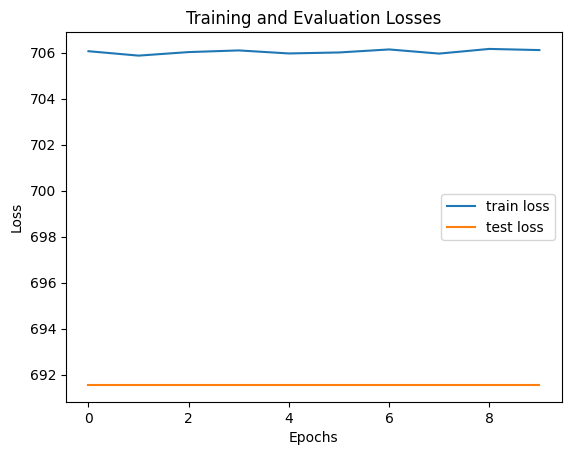

In [105]:
# ----------------------------------------------------------------------------------------------------------------
#    initera modell, loss_function, optimizer & dataloader


#model = NeuralNetwork(input_size)
model = model.to(device)                                  # förbered modellen för GPU

optimizer = SGD(model.parameters(), lr = learning_rate)
loss_function = torch.nn.L1Loss()

train_dataloader = DataLoader(training_set,                 
                              batch_size = batch_size,       
                              shuffle=True)


# ----------------------------------------------------------------------------------------------------------------
#    träna



batch_train_losses = []

epoch_train_losses = []
epoch_evaluation_losses = []

for i in range(epochs):
    
    model.train()

    running_loss = 0
    
    for batch in train_dataloader:
        
        y_true = batch[1]
        input_features = batch[0]
        
        y_pred=model(input_features)
        loss=loss_function(y_pred, y_true)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        batch_loss = loss.item()
        batch_train_losses.append(batch_loss)
    
    epoch_average_loss = np.average(batch_train_losses[-len(train_dataloader):])

    epoch_train_losses.append(epoch_average_loss)

# ----------------------------------------------------------------------------------------------------------------
#   evalueringssektion 

    model.eval()
    
    y_true = y_test
    input_features = x_test
    
    y_pred = model(input_features)
    loss = loss_function(y_pred, y_true)
    
    evaluation_loss = loss.item()
    epoch_evaluation_losses.append(evaluation_loss)

# ----------------------------------------------------------------------------------------------------------------
#   plotta resultat 

plt.plot(epoch_train_losses, label = 'train loss')
plt.plot(epoch_evaluation_losses, label = 'test loss')
plt.legend()

# axis labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Losses')

plt.show()

## Uppgifter

<br/> 

**1)**

Vi har ändrat på vad vi plottar. Lägg märke till att train loss nu är smooth! 

Vad är det vi gjort?! Är det rimtligt att göra så?

Svar:
- Genom att använda genomsnitt per epoch blir det lättare att följa trenden, istället för att överanalysera varje batch.
- Däremot kan man missa problem som orsakas av outliers eller om shufflingen inte fungerar optimalt.

<br/>

**2)**

Titta på train- och test losskurvorna från körning ovan (med default inställningar). 

Hur tolkar du resultatet? Vad bör man göra i ett sånt här scenario?

SVAR: 
- Modellen overfittar på train datan och generaliserar dåligt på test datan med stora fluktationer.
- Lägre inlärningshastighet (0.001) ger stabilare och mer konsekvent träning samt bättre generalisering, medan högre hastighet (0.01) orsakar osäkerhet och överanpassning.

<br/>

**3)**

Hur ser nätverket ut som du precis tränat? Rita upp den.

In [106]:
# from torchviz import make_dot
# from IPython.display import Image

# # get one batch of data from the train_dataloader
# for batch in train_dataloader:
#     input_features = batch[0].to(device)  # extract input data (e.g., images, features)
#     break  # we only need one batch for visualization

# # forward pass through the model
# y = model(input_features)

# # create the computation graph for the output (mean of y for simplicity)
# make_dot(y.mean(), params=dict(model.named_parameters())).render("model_graph", format="png")

# Image(filename='model_graph.png')



In [107]:
model

NeuralNetwork(
  (fc1): Linear(in_features=18, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
)

In [108]:
summary(model)

Layer (type:depth-idx)                   Param #
NeuralNetwork                            --
├─Linear: 1-1                            570
├─Linear: 1-2                            930
├─Linear: 1-3                            31
├─ReLU: 1-4                              --
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0

<br/>

**4)**

Vi ska nu utföra en random search av hyperparameters, och vi ska endast göra detta över hyperparametern antal_neurons_per_layer.

Observera följande lista

antal_neurons_per_layer = [1, 5, 10, 20, 30, 50, 100]

Gör en loop och träna nu ett nätverk med dessa värden på antal neuroner per lager.

Bygg och träna samtliga nätverk med 

antal_lager =  4

batch_size = 6

learning_rate = 0.01

epochs = 20

Vad drar du för slutsats?



**OBS, ibland kan det se ut som att nätverket inte lärt sig något alls. Och så kan det vara, vi hade otur med matematiken helt enkelt. Stora nätverk kan ibland ta mer/mindre tid att komma igång att lära sig. Testa köra igen, och hoppas på lite mer tur! Du kanske också kan testa öka antal epoker.**

**Vi kommer lära oss strategier för att motverka detta vid ett senare skede**


<br/>

<br/>